# Install modules

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
import tensorflow.keras.backend as K
import os
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Get data in right format

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("preprocesseddata.csv",index_col="datetime")

#splitting into target and input variables
X = df.drop(['classification_region1', 'classification_region2', 'classification_region3'], axis=1)
X = X.drop(X.columns[:30], axis=1)
display(X)

y1 = df[['classification_region1']]
y2 = df[['classification_region2']]
y3 = df[['classification_region3']]

# Define the number of splits for the TimeSeriesSplit
n_splits = 5

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

,day,month,weekday,dayofyear,weekofyear,quarter,3.feed_5975.PM2_5_region_2_pre_1h,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_region_2_pre_1h,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_region_2_pre_1h,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB_region_2_pre_1h,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3_region_1_pre_8h,3.feed_24.PM10_UG_M3_region_0_pre_8h,3.feed_23.PM10_UG_M3_region_1_pre_8h,3.feed_23.CO_PPM..3.feed_23.CO_PPB_region_1_pre_8h,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_region_1_pre_8h,3.feed_1.SO2_PPM_region_1_pre_8h,3.feed_1.H2S_PPM_region_1_pre_8h,3.feed_1.SIGTHETA_DEG_region_1_pre_8h,3.feed_1.SONICWD_DEG_region_1_pre_8h,3.feed_1.SONICWS_MPH_region_1_pre_8h
datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-07 00:00:00+00:00,-0.990413,1.324511,-1.499089,1.248898,1.245267,1.372053,-0.255372,0.412642,1.512580,2.409115,...,-1.669195,-0.938268,-1.027351,-0.372028,-1.442388,0.850899,-0.390935,1.130296,-1.128911,-0.654275
2016-11-08 00:00:00+00:00,-0.876473,1.324511,-0.998906,1.258249,1.245267,1.372053,1.080615,0.835235,2.368568,2.397179,...,0.350264,0.429362,1.288427,0.910943,0.223404,1.617984,0.022140,1.131835,-1.051112,-0.996113
2016-11-09 00:00:00+00:00,-0.762532,1.324511,-0.498723,1.267601,1.245267,1.372053,1.161605,-0.106479,0.134204,0.757347,...,1.185281,1.667114,3.492098,2.132820,1.306383,0.622203,-0.390935,-0.366304,-0.918008,-0.574013
2016-11-10 00:00:00+00:00,-0.648591,1.324511,0.001460,1.276953,1.245267,1.372053,-0.620180,-0.458848,0.540070,0.514072,...,-0.685522,-0.101660,0.205000,-0.616403,-0.064570,-0.464102,-0.390935,-0.322474,0.127105,0.221108
2016-11-11 00:00:00+00:00,-0.534650,1.324511,0.501643,1.286305,1.245267,1.372053,-0.790260,-0.321352,-0.188596,0.261703,...,-1.347148,-0.945050,-0.936281,-0.952419,-1.599610,-0.464102,-0.390935,-0.334649,1.660266,-0.375233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12 00:00:00+00:00,-0.420709,0.180053,-1.499089,0.136020,0.133847,0.484132,-0.765963,-0.629157,-1.217981,-1.043911,...,4.074987,4.712686,5.185611,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-07-13 00:00:00+00:00,-0.306769,0.180053,-0.998906,0.145372,0.133847,0.484132,-0.517358,-0.850237,-1.236907,-1.137696,...,2.084179,1.272752,1.819622,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-07-14 00:00:00+00:00,-0.192828,0.180053,-0.498723,0.154724,0.133847,0.484132,-0.546553,-0.529716,-1.175922,-1.028564,...,2.175437,1.448458,1.740732,-1.000000,2.892005,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


# Build model

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [4]:
def transformer_model(input_shape, num_classes, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units,
                      dropout=0, mlp_dropout=0):
    
    output_regions = []
    input_layer = keras.Input(shape=input_shape) 
        
    #REGION1
    #create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x1 = transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout)

    x1 = layers.GlobalAveragePooling1D(data_format="channels_first")(x1)

    #creaete dense layer
    for dim in mlp_units:
        x1 = layers.Dense(dim, activation="relu")(x1)
        x1 = layers.Dropout(mlp_dropout)(x1)
        
          
    outputs1 = layers.Dense(num_classes, activation="sigmoid", name="output1")(x1)
    output_regions.append(outputs1)
    
    #REGION1
    #create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x2 = transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout)

    x2 = layers.GlobalAveragePooling1D(data_format="channels_first")(x2)

    #creaete dense layer
    for dim in mlp_units:
        x2 = layers.Dense(dim, activation="relu")(x2)
        x2 = layers.Dropout(mlp_dropout)(x2)
        
          
    outputs2 = layers.Dense(num_classes, activation="sigmoid", name="output2")(x2)
    output_regions.append(outputs2)
    
    
    #REGION1
    #create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x3 = transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout)

    x3 = layers.GlobalAveragePooling1D(data_format="channels_first")(x3)

    #creaete dense layer
    for dim in mlp_units:
        x3 = layers.Dense(dim, activation="relu")(x3)
        x3 = layers.Dropout(mlp_dropout)(x3)
        
          
    outputs3 = layers.Dense(num_classes, activation="sigmoid", name="output3")(x3)
    output_regions.append(outputs3)
        
    model = keras.Model(inputs=input_layer, outputs= output_regions)

    return model

# Train model using timeseries split cross validation

In [5]:
epochs = 200
batch_size = 32



# Define the lists to store the training and validation scores
trainf1_scores_output1 = []
trainf1_scores_output2 = []
trainf1_scores_output3 = []
valf1_scores_output1 = []
valf1_scores_output2 = []
valf1_scores_output3 = []

# Loop over the splits of the TimeSeriesSplit
for train_index, val_index in tscv.split(X):

    # Split the data into training and validation sets
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]
    y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]
    y3_train, y3_val = y3.iloc[train_index], y3.iloc[val_index]
    
    # One-hot encode the binary targets
    y1_train = to_categorical(y1_train, num_classes=2)
    y1_val = to_categorical(y1_val, num_classes=2)
    y2_train = to_categorical(y2_train, num_classes=2)
    y2_val = to_categorical(y2_val, num_classes=2)
    y3_train = to_categorical(y3_train, num_classes=2)
    y3_val = to_categorical(y3_val, num_classes=2)
    
    # Convert to numpy and reshape to 3D
    x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_val = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))
    
    #create some callbacks to improve the model
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "timeseries_transformer", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
    ]
    
    model = transformer_model(input_shape=x_train.shape[1:], 
    num_classes=2,
    head_size=64,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.2
    )
    
    
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )

    # Fit the model
    history = model.fit(
        x_train,
        [y1_train, y2_train, y3_train],
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_val, [y1_val, y2_val, y3_val]),
        verbose=1,
    )
    
    print(history.history.keys())
    
    
    #Calculate training performance using f1-score
    precision1, recall1 = history.history["output1_precision"][-1], history.history["output1_recall"][-1]
    trainf1_scores_output1.append((2 * precision1 * recall1 / (precision1 + recall1)))
    precision2, recall2 = history.history["output2_precision"][-1], history.history["output2_recall"][-1]
    trainf1_scores_output2.append((2 * precision2 * recall2 / (precision2 + recall2)))
    precision3, recall3 = history.history["output3_precision"][-1], history.history["output3_recall"][-1]
    trainf1_scores_output3.append((2 * precision3 * recall3 / (precision3 + recall3)))
    
    #Calculate training performance using f1-score
    val_precision1, val_recall1 = history.history["val_output1_precision"][-1], history.history["val_output1_recall"][-1]
    valf1_scores_output1.append((2 * val_precision1 * val_recall1 / (val_precision1 + val_recall1)))
    val_precision2, val_recall2 = history.history["val_output2_precision"][-1], history.history["val_output2_recall"][-1]
    valf1_scores_output2.append((2 * val_precision2 * val_recall2 / (val_precision2 + val_recall2)))
    val_precision3, val_recall3 = history.history["val_output3_precision"][-1], history.history["val_output3_recall"][-1]
    valf1_scores_output3.append((2 * val_precision3 * val_recall3 / (val_precision3 + val_recall3)))

#Define the filename for the saved model
model_filename = "timeseries_transformer"
#Save the model
model.save(model_filename)


print("Output 1 Training F1: {:.2f}%".format(trainf1_scores_output1[-1] * 100))
print("Output 1 Validation F1: {:.2f}%".format(valf1_scores_output1[-1] * 100))
print("Output 2 Training F1: {:.2f}%".format(trainf1_scores_output2[-1] * 100))
print("Output 2 Validation F1: {:.2f}%".format(valf1_scores_output2[-1] * 100))
print("Output 3 Training F1: {:.2f}%".format(trainf1_scores_output3[-1] * 100))
print("Output 3 Validation F1: {:.2f}%".format(valf1_scores_output3[-1] * 100))

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 1.9477 - output1_loss: 0.6665 - output2_loss: 0.5754 - output3_loss: 0.7058 - output1_precision: 0.6821 - output1_recall: 0.6632 - output1_auc: 0.7251 - output2_precision: 0.6965 - output2_recall: 0.7569 - output2_auc: 0.7917 - output3_precision: 0.6246 - output3_recall: 0.6875 - output3_auc: 0.6819

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


9/9 [==============================] - 28s 3s/step - loss: 1.9477 - output1_loss: 0.6665 - output2_loss: 0.5754 - output3_loss: 0.7058 - output1_precision: 0.6821 - output1_recall: 0.6632 - output1_auc: 0.7251 - output2_precision: 0.6965 - output2_recall: 0.7569 - output2_auc: 0.7917 - output3_precision: 0.6246 - output3_recall: 0.6875 - output3_auc: 0.6819 - val_loss: 1.0857 - val_output1_loss: 0.2799 - val_output2_loss: 0.3865 - val_output3_loss: 0.4193 - val_output1_precision: 0.9176 - val_output1_recall: 0.8982 - val_output1_auc: 0.9639 - val_output2_precision: 0.8345 - val_output2_recall: 0.8491 - val_output2_auc: 0.9067 - val_output3_precision: 0.8082 - val_output3_recall: 0.8281 - val_output3_auc: 0.8873 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 20s 2s/step - loss: 0.7147 - output1_loss: 0.1118 - output2_loss: 0.2235 - output3_loss: 0.3794 - output1_precision: 0.9759 - output1_recall: 0.9826 - output1_auc: 0.9871 - output2_precision: 0.9263 - output2_recall

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


9/9 [==============================] - 24s 3s/step - loss: 0.3823 - output1_loss: 0.0527 - output2_loss: 0.0989 - output3_loss: 0.2307 - output1_precision: 0.9896 - output1_recall: 0.9896 - output1_auc: 0.9937 - output2_precision: 0.9618 - output2_recall: 0.9618 - output2_auc: 0.9942 - output3_precision: 0.9103 - output3_recall: 0.9167 - output3_auc: 0.9669 - val_loss: 0.9941 - val_output1_loss: 0.2929 - val_output2_loss: 0.3952 - val_output3_loss: 0.3061 - val_output1_precision: 0.9404 - val_output1_recall: 0.9404 - val_output1_auc: 0.9624 - val_output2_precision: 0.8397 - val_output2_recall: 0.8456 - val_output2_auc: 0.9319 - val_output3_precision: 0.8596 - val_output3_recall: 0.8596 - val_output3_auc: 0.9445 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - ETA: 0s - loss: 0.3381 - output1_loss: 0.0445 - output2_loss: 0.0951 - output3_loss: 0.1984 - output1_precision: 0.9896 - output1_recall: 0.9896 - output1_auc: 0.9964 - output2_precision: 0.9621 - output2_recall: 0.

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


9/9 [==============================] - 24s 3s/step - loss: 0.3381 - output1_loss: 0.0445 - output2_loss: 0.0951 - output3_loss: 0.1984 - output1_precision: 0.9896 - output1_recall: 0.9896 - output1_auc: 0.9964 - output2_precision: 0.9621 - output2_recall: 0.9688 - output2_auc: 0.9948 - output3_precision: 0.9141 - output3_recall: 0.9236 - output3_auc: 0.9766 - val_loss: 0.9512 - val_output1_loss: 0.2548 - val_output2_loss: 0.4004 - val_output3_loss: 0.2959 - val_output1_precision: 0.9404 - val_output1_recall: 0.9404 - val_output1_auc: 0.9689 - val_output2_precision: 0.8403 - val_output2_recall: 0.8491 - val_output2_auc: 0.9337 - val_output3_precision: 0.8611 - val_output3_recall: 0.8702 - val_output3_auc: 0.9480 - lr: 0.0010
Epoch 6/200
9/9 [==============================] - 21s 2s/step - loss: 0.2963 - output1_loss: 0.0281 - output2_loss: 0.0925 - output3_loss: 0.1757 - output1_precision: 0.9931 - output1_recall: 0.9931 - output1_auc: 0.9995 - output2_precision: 0.9690 - output2_recall

Epoch 16/200
9/9 [==============================] - 21s 2s/step - loss: 0.1059 - output1_loss: 0.0067 - output2_loss: 0.0275 - output3_loss: 0.0718 - output1_precision: 1.0000 - output1_recall: 0.9965 - output1_auc: 1.0000 - output2_precision: 0.9931 - output2_recall: 0.9931 - output2_auc: 0.9998 - output3_precision: 0.9759 - output3_recall: 0.9861 - output3_auc: 0.9982 - val_loss: 1.1300 - val_output1_loss: 0.3427 - val_output2_loss: 0.4788 - val_output3_loss: 0.3085 - val_output1_precision: 0.9404 - val_output1_recall: 0.9404 - val_output1_auc: 0.9592 - val_output2_precision: 0.8551 - val_output2_recall: 0.8491 - val_output2_auc: 0.9352 - val_output3_precision: 0.8671 - val_output3_recall: 0.8702 - val_output3_auc: 0.9510 - lr: 0.0010
Epoch 17/200
9/9 [==============================] - 21s 2s/step - loss: 0.0986 - output1_loss: 0.0197 - output2_loss: 0.0235 - output3_loss: 0.0554 - output1_precision: 0.9931 - output1_recall: 0.9931 - output1_auc: 0.9998 - output2_precision: 0.9965 - 

18/18 [==============================] - ETA: 0s - loss: 1.4004 - output1_loss: 0.4773 - output2_loss: 0.4633 - output3_loss: 0.4598 - output1_precision: 0.8330 - output1_recall: 0.7138 - output1_auc: 0.8631 - output2_precision: 0.8166 - output2_recall: 0.7539 - output2_auc: 0.8749 - output3_precision: 0.7831 - output3_recall: 0.8255 - output3_auc: 0.8687

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 44s 2s/step - loss: 1.4004 - output1_loss: 0.4773 - output2_loss: 0.4633 - output3_loss: 0.4598 - output1_precision: 0.8330 - output1_recall: 0.7138 - output1_auc: 0.8631 - output2_precision: 0.8166 - output2_recall: 0.7539 - output2_auc: 0.8749 - output3_precision: 0.7831 - output3_recall: 0.8255 - output3_auc: 0.8687 - val_loss: 1.6302 - val_output1_loss: 0.7353 - val_output2_loss: 0.4582 - val_output3_loss: 0.4368 - val_output1_precision: 0.8688 - val_output1_recall: 0.8596 - val_output1_auc: 0.8190 - val_output2_precision: 0.8182 - val_output2_recall: 0.8211 - val_output2_auc: 0.8923 - val_output3_precision: 0.8063 - val_output3_recall: 0.8912 - val_output3_auc: 0.8949 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.7043 - output1_loss: 0.1805 - output2_loss: 0.2533 - output3_loss: 0.2705 - output1_precision: 0.9635 - output1_recall: 0.9668 - output1_auc: 0.9733 - output2_precision: 0.9012 - output2_recall

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 39s 2s/step - loss: 0.7043 - output1_loss: 0.1805 - output2_loss: 0.2533 - output3_loss: 0.2705 - output1_precision: 0.9635 - output1_recall: 0.9668 - output1_auc: 0.9733 - output2_precision: 0.9012 - output2_recall: 0.9075 - output2_auc: 0.9626 - output3_precision: 0.8849 - output3_recall: 0.8988 - output3_auc: 0.9550 - val_loss: 1.4453 - val_output1_loss: 0.6732 - val_output2_loss: 0.3897 - val_output3_loss: 0.3824 - val_output1_precision: 0.8577 - val_output1_recall: 0.8035 - val_output1_auc: 0.8308 - val_output2_precision: 0.8657 - val_output2_recall: 0.8140 - val_output2_auc: 0.9114 - val_output3_precision: 0.8444 - val_output3_recall: 0.8947 - val_output3_auc: 0.9156 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.5545 - output1_loss: 0.1224 - output2_loss: 0.1956 - output3_loss: 0.2365 - output1_precision: 0.9615 - output1_recall: 0.9581 - output1_auc: 0.9907 - output2_precision: 0.9288 - output2_recall

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


18/18 [==============================] - 40s 2s/step - loss: 0.5545 - output1_loss: 0.1224 - output2_loss: 0.1956 - output3_loss: 0.2365 - output1_precision: 0.9615 - output1_recall: 0.9581 - output1_auc: 0.9907 - output2_precision: 0.9288 - output2_recall: 0.9110 - output2_auc: 0.9764 - output3_precision: 0.8985 - output3_recall: 0.9110 - output3_auc: 0.9657 - val_loss: 1.3814 - val_output1_loss: 0.6182 - val_output2_loss: 0.3970 - val_output3_loss: 0.3662 - val_output1_precision: 0.8271 - val_output1_recall: 0.7719 - val_output1_auc: 0.8374 - val_output2_precision: 0.8445 - val_output2_recall: 0.8386 - val_output2_auc: 0.9130 - val_output3_precision: 0.8495 - val_output3_recall: 0.8912 - val_output3_auc: 0.9216 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - 38s 2s/step - loss: 0.4374 - output1_loss: 0.1037 - output2_loss: 0.1510 - output3_loss: 0.1827 - output1_precision: 0.9669 - output1_recall: 0.9686 - output1_auc: 0.9924 - output2_precision: 0.9260 - output2_re

Epoch 14/200
18/18 [==============================] - 36s 2s/step - loss: 0.1216 - output1_loss: 0.0233 - output2_loss: 0.0445 - output3_loss: 0.0537 - output1_precision: 0.9896 - output1_recall: 0.9930 - output1_auc: 0.9999 - output2_precision: 0.9930 - output2_recall: 0.9860 - output2_auc: 0.9994 - output3_precision: 0.9913 - output3_recall: 0.9913 - output3_auc: 0.9994 - val_loss: 1.6758 - val_output1_loss: 0.8440 - val_output2_loss: 0.4682 - val_output3_loss: 0.3636 - val_output1_precision: 0.8636 - val_output1_recall: 0.8667 - val_output1_auc: 0.8566 - val_output2_precision: 0.8456 - val_output2_recall: 0.8456 - val_output2_auc: 0.9106 - val_output3_precision: 0.8819 - val_output3_recall: 0.8912 - val_output3_auc: 0.9351 - lr: 0.0010
Epoch 15/200
18/18 [==============================] - 35s 2s/step - loss: 0.1284 - output1_loss: 0.0294 - output2_loss: 0.0470 - output3_loss: 0.0521 - output1_precision: 0.9878 - output1_recall: 0.9895 - output1_auc: 0.9996 - output2_precision: 0.991

27/27 [==============================] - ETA: 0s - loss: 1.5618 - output1_loss: 0.6216 - output2_loss: 0.4287 - output3_loss: 0.5115 - output1_precision: 0.7430 - output1_recall: 0.7075 - output1_auc: 0.8271 - output2_precision: 0.8042 - output2_recall: 0.8089 - output2_auc: 0.8918 - output3_precision: 0.7786 - output3_recall: 0.7459 - output3_auc: 0.8419

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 81s 3s/step - loss: 1.5618 - output1_loss: 0.6216 - output2_loss: 0.4287 - output3_loss: 0.5115 - output1_precision: 0.7430 - output1_recall: 0.7075 - output1_auc: 0.8271 - output2_precision: 0.8042 - output2_recall: 0.8089 - output2_auc: 0.8918 - output3_precision: 0.7786 - output3_recall: 0.7459 - output3_auc: 0.8419 - val_loss: 2.9235 - val_output1_loss: 1.7312 - val_output2_loss: 0.6481 - val_output3_loss: 0.5442 - val_output1_precision: 0.6246 - val_output1_recall: 0.6246 - val_output1_auc: 0.6776 - val_output2_precision: 0.6949 - val_output2_recall: 0.7193 - val_output2_auc: 0.7822 - val_output3_precision: 0.7045 - val_output3_recall: 0.7193 - val_output3_auc: 0.8311 - lr: 0.0010
Epoch 2/200
27/27 [==============================] - ETA: 0s - loss: 0.8080 - output1_loss: 0.2436 - output2_loss: 0.2729 - output3_loss: 0.2915 - output1_precision: 0.9278 - output1_recall: 0.9289 - output1_auc: 0.9604 - output2_precision: 0.8939 - output2_recall

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


27/27 [==============================] - 81s 3s/step - loss: 0.8080 - output1_loss: 0.2436 - output2_loss: 0.2729 - output3_loss: 0.2915 - output1_precision: 0.9278 - output1_recall: 0.9289 - output1_auc: 0.9604 - output2_precision: 0.8939 - output2_recall: 0.8939 - output2_auc: 0.9557 - output3_precision: 0.8721 - output3_recall: 0.8823 - output3_auc: 0.9484 - val_loss: 2.0440 - val_output1_loss: 0.8233 - val_output2_loss: 0.6824 - val_output3_loss: 0.5384 - val_output1_precision: 0.6502 - val_output1_recall: 0.6456 - val_output1_auc: 0.7118 - val_output2_precision: 0.6852 - val_output2_recall: 0.7333 - val_output2_auc: 0.7841 - val_output3_precision: 0.7282 - val_output3_recall: 0.7333 - val_output3_auc: 0.8443 - lr: 0.0010
Epoch 3/200
27/27 [==============================] - 63s 2s/step - loss: 0.6527 - output1_loss: 0.1861 - output2_loss: 0.2320 - output3_loss: 0.2347 - output1_precision: 0.9380 - output1_recall: 0.9347 - output1_auc: 0.9778 - output2_precision: 0.8995 - output2_re

Epoch 13/200
27/27 [==============================] - 62s 2s/step - loss: 0.1921 - output1_loss: 0.0566 - output2_loss: 0.0570 - output3_loss: 0.0784 - output1_precision: 0.9825 - output1_recall: 0.9814 - output1_auc: 0.9980 - output2_precision: 0.9895 - output2_recall: 0.9895 - output2_auc: 0.9994 - output3_precision: 0.9745 - output3_recall: 0.9790 - output3_auc: 0.9975 - val_loss: 2.3631 - val_output1_loss: 1.0572 - val_output2_loss: 0.6931 - val_output3_loss: 0.6127 - val_output1_precision: 0.6713 - val_output1_recall: 0.6737 - val_output1_auc: 0.7317 - val_output2_precision: 0.7201 - val_output2_recall: 0.7404 - val_output2_auc: 0.8124 - val_output3_precision: 0.7456 - val_output3_recall: 0.7404 - val_output3_auc: 0.8489 - lr: 0.0010
Epoch 14/200
27/27 [==============================] - 63s 2s/step - loss: 0.1750 - output1_loss: 0.0543 - output2_loss: 0.0615 - output3_loss: 0.0593 - output1_precision: 0.9860 - output1_recall: 0.9872 - output1_auc: 0.9979 - output2_precision: 0.987

36/36 [==============================] - ETA: 0s - loss: 1.5746 - output1_loss: 0.5671 - output2_loss: 0.5073 - output3_loss: 0.5002 - output1_precision: 0.7427 - output1_recall: 0.7603 - output1_auc: 0.8156 - output2_precision: 0.7561 - output2_recall: 0.7918 - output2_auc: 0.8458 - output3_precision: 0.7475 - output3_recall: 0.7927 - output3_auc: 0.8527

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 81s 2s/step - loss: 1.5746 - output1_loss: 0.5671 - output2_loss: 0.5073 - output3_loss: 0.5002 - output1_precision: 0.7427 - output1_recall: 0.7603 - output1_auc: 0.8156 - output2_precision: 0.7561 - output2_recall: 0.7918 - output2_auc: 0.8458 - output3_precision: 0.7475 - output3_recall: 0.7927 - output3_auc: 0.8527 - val_loss: 1.8341 - val_output1_loss: 0.6695 - val_output2_loss: 0.5613 - val_output3_loss: 0.6033 - val_output1_precision: 0.6724 - val_output1_recall: 0.6842 - val_output1_auc: 0.7387 - val_output2_precision: 0.7059 - val_output2_recall: 0.7579 - val_output2_auc: 0.8087 - val_output3_precision: 0.7133 - val_output3_recall: 0.7333 - val_output3_auc: 0.8234 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 97s 3s/step - loss: 1.0258 - output1_loss: 0.3583 - output2_loss: 0.3465 - output3_loss: 0.3210 - output1_precision: 0.8552 - output1_recall: 0.8626 - output1_auc: 0.9212 - output2_precision: 0.8478 - output2_re

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


36/36 [==============================] - 98s 3s/step - loss: 0.8889 - output1_loss: 0.3193 - output2_loss: 0.2946 - output3_loss: 0.2750 - output1_precision: 0.8554 - output1_recall: 0.8696 - output1_auc: 0.9377 - output2_precision: 0.8682 - output2_recall: 0.8705 - output2_auc: 0.9470 - output3_precision: 0.8854 - output3_recall: 0.8924 - output3_auc: 0.9539 - val_loss: 1.7447 - val_output1_loss: 0.6547 - val_output2_loss: 0.5663 - val_output3_loss: 0.5237 - val_output1_precision: 0.6756 - val_output1_recall: 0.7088 - val_output1_auc: 0.7511 - val_output2_precision: 0.7276 - val_output2_recall: 0.7404 - val_output2_auc: 0.8272 - val_output3_precision: 0.7285 - val_output3_recall: 0.7439 - val_output3_auc: 0.8560 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 86s 2s/step - loss: 0.7714 - output1_loss: 0.2649 - output2_loss: 0.2646 - output3_loss: 0.2419 - output1_precision: 0.8935 - output1_recall: 0.9029 - output1_auc: 0.9576 - output2_precision: 0.8897 - output2_re

Epoch 14/200
36/36 [==============================] - 88s 2s/step - loss: 0.2720 - output1_loss: 0.1038 - output2_loss: 0.0929 - output3_loss: 0.0754 - output1_precision: 0.9642 - output1_recall: 0.9659 - output1_auc: 0.9951 - output2_precision: 0.9763 - output2_recall: 0.9711 - output2_auc: 0.9967 - output3_precision: 0.9764 - output3_recall: 0.9790 - output3_auc: 0.9982 - val_loss: 1.9525 - val_output1_loss: 0.7694 - val_output2_loss: 0.6387 - val_output3_loss: 0.5445 - val_output1_precision: 0.6791 - val_output1_recall: 0.7053 - val_output1_auc: 0.7596 - val_output2_precision: 0.7595 - val_output2_recall: 0.7754 - val_output2_auc: 0.8388 - val_output3_precision: 0.7812 - val_output3_recall: 0.7895 - val_output3_auc: 0.8800 - lr: 0.0010
Epoch 15/200
36/36 [==============================] - 88s 2s/step - loss: 0.2474 - output1_loss: 0.0919 - output2_loss: 0.0728 - output3_loss: 0.0827 - output1_precision: 0.9737 - output1_recall: 0.9729 - output1_auc: 0.9968 - output2_precision: 0.979

45/45 [==============================] - ETA: 0s - loss: 1.5409 - output1_loss: 0.5231 - output2_loss: 0.5168 - output3_loss: 0.5009 - output1_precision: 0.7439 - output1_recall: 0.7934 - output1_auc: 0.8384 - output2_precision: 0.7639 - output2_recall: 0.7388 - output2_auc: 0.8353 - output3_precision: 0.7784 - output3_recall: 0.7675 - output3_auc: 0.8475

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 113s 2s/step - loss: 1.5409 - output1_loss: 0.5231 - output2_loss: 0.5168 - output3_loss: 0.5009 - output1_precision: 0.7439 - output1_recall: 0.7934 - output1_auc: 0.8384 - output2_precision: 0.7639 - output2_recall: 0.7388 - output2_auc: 0.8353 - output3_precision: 0.7784 - output3_recall: 0.7675 - output3_auc: 0.8475 - val_loss: 1.3135 - val_output1_loss: 0.4671 - val_output2_loss: 0.4258 - val_output3_loss: 0.4205 - val_output1_precision: 0.7849 - val_output1_recall: 0.7684 - val_output1_auc: 0.8648 - val_output2_precision: 0.7966 - val_output2_recall: 0.8246 - val_output2_auc: 0.8904 - val_output3_precision: 0.7964 - val_output3_recall: 0.7825 - val_output3_auc: 0.8896 - lr: 0.0010
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 1.0721 - output1_loss: 0.3771 - output2_loss: 0.3515 - output3_loss: 0.3435 - output1_precision: 0.8347 - output1_recall: 0.8382 - output1_auc: 0.9131 - output2_precision: 0.8443 - output2_recal

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 137s 3s/step - loss: 1.0721 - output1_loss: 0.3771 - output2_loss: 0.3515 - output3_loss: 0.3435 - output1_precision: 0.8347 - output1_recall: 0.8382 - output1_auc: 0.9131 - output2_precision: 0.8443 - output2_recall: 0.8431 - output2_auc: 0.9237 - output3_precision: 0.8551 - output3_recall: 0.8557 - output3_auc: 0.9276 - val_loss: 1.2150 - val_output1_loss: 0.4265 - val_output2_loss: 0.4013 - val_output3_loss: 0.3872 - val_output1_precision: 0.8144 - val_output1_recall: 0.8316 - val_output1_auc: 0.8847 - val_output2_precision: 0.8188 - val_output2_recall: 0.8246 - val_output2_auc: 0.8997 - val_output3_precision: 0.8352 - val_output3_recall: 0.8000 - val_output3_auc: 0.9071 - lr: 0.0010
Epoch 3/200
45/45 [==============================] - ETA: 0s - loss: 0.9194 - output1_loss: 0.3272 - output2_loss: 0.3110 - output3_loss: 0.2811 - output1_precision: 0.8652 - output1_recall: 0.8627 - output1_auc: 0.9351 - output2_precision: 0.8609 - output2_recal

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


45/45 [==============================] - 132s 3s/step - loss: 0.9194 - output1_loss: 0.3272 - output2_loss: 0.3110 - output3_loss: 0.2811 - output1_precision: 0.8652 - output1_recall: 0.8627 - output1_auc: 0.9351 - output2_precision: 0.8609 - output2_recall: 0.8627 - output2_auc: 0.9402 - output3_precision: 0.8764 - output3_recall: 0.8838 - output3_auc: 0.9525 - val_loss: 1.1566 - val_output1_loss: 0.4176 - val_output2_loss: 0.3773 - val_output3_loss: 0.3617 - val_output1_precision: 0.8179 - val_output1_recall: 0.8351 - val_output1_auc: 0.8908 - val_output2_precision: 0.8136 - val_output2_recall: 0.8421 - val_output2_auc: 0.9109 - val_output3_precision: 0.8387 - val_output3_recall: 0.8211 - val_output3_auc: 0.9188 - lr: 0.0010
Epoch 4/200
45/45 [==============================] - 118s 3s/step - loss: 0.8199 - output1_loss: 0.2849 - output2_loss: 0.2793 - output3_loss: 0.2557 - output1_precision: 0.8751 - output1_recall: 0.8732 - output1_auc: 0.9506 - output2_precision: 0.8766 - output2_

Epoch 14/200
45/45 [==============================] - 116s 3s/step - loss: 0.3259 - output1_loss: 0.1198 - output2_loss: 0.1035 - output3_loss: 0.1027 - output1_precision: 0.9600 - output1_recall: 0.9573 - output1_auc: 0.9930 - output2_precision: 0.9632 - output2_recall: 0.9713 - output2_auc: 0.9954 - output3_precision: 0.9670 - output3_recall: 0.9657 - output3_auc: 0.9950 - val_loss: 1.3457 - val_output1_loss: 0.5148 - val_output2_loss: 0.4369 - val_output3_loss: 0.3939 - val_output1_precision: 0.7979 - val_output1_recall: 0.8035 - val_output1_auc: 0.8818 - val_output2_precision: 0.8123 - val_output2_recall: 0.8351 - val_output2_auc: 0.9070 - val_output3_precision: 0.8511 - val_output3_recall: 0.8421 - val_output3_auc: 0.9243 - lr: 0.0010
Epoch 15/200
45/45 [==============================] - 117s 3s/step - loss: 0.2972 - output1_loss: 0.1116 - output2_loss: 0.0940 - output3_loss: 0.0917 - output1_precision: 0.9640 - output1_recall: 0.9573 - output1_auc: 0.9937 - output2_precision: 0.9

INFO:tensorflow:Assets written to: timeseries_transformer\assets


INFO:tensorflow:Assets written to: timeseries_transformer\assets


Output 1 Training F1: 98.56%
Output 1 Validation F1: 78.53%
Output 2 Training F1: 99.37%
Output 2 Validation F1: 83.28%
Output 3 Training F1: 99.05%
Output 3 Validation F1: 83.10%


In [13]:
print(trainf1_scores_output1)
print(valf1_scores_output1)
print(trainf1_scores_output2)
print(valf1_scores_output2)
print(trainf1_scores_output3)
print(valf1_scores_output3, "\n")

#mean output of all splits for taining and validation per region 
print("Mean output training region 1: ",np.mean(trainf1_scores_output1))
print("Mean output validation region 1: ",np.mean(valf1_scores_output1))
print("Mean output training region 2: ",np.mean(trainf1_scores_output2))
print("Mean output validation region 2: ",np.mean(valf1_scores_output2))
print("Mean output training region 3: ",np.mean(trainf1_scores_output3))
print("Mean output validation region 3: ",np.mean(valf1_scores_output3), "\n")


#mean output of training and testing of all regions
print("Mean output of all regions training: ",np.mean([trainf1_scores_output1, trainf1_scores_output2, trainf1_scores_output3]))
print("Mean output of all regions validation: ",np.mean([valf1_scores_output1, valf1_scores_output2, valf1_scores_output3]))

[0.9982608762110113, 0.9982547760009766, 0.9935934749341735, 0.9912663853146888, 0.9856291541573682]
[0.9403508901596069, 0.8571428602264599, 0.6619964799351964, 0.6631762684085956, 0.7853403281055811]
[0.9982668872954895, 0.9956255513480019, 0.997668981552124, 0.987308551528081, 0.9937063091288243]
[0.8526315689086914, 0.8315789699554443, 0.716521737589051, 0.76041665975289, 0.8327525850973784]
[0.9948007088434615, 0.9904264640669623, 0.9930070042610168, 0.989039914004515, 0.990529649618521]
[0.8680555573147203, 0.8701754212379456, 0.7256637199323285, 0.7929824590682983, 0.8309859123145261] 

Mean output training region 1:  0.9934009333236438
Mean output validation region 1:  0.781601365367088
Mean output training region 2:  0.9945152561705042
Mean output validation region 2:  0.7987803042606909
Mean output training region 3:  0.9915607481588953
Mean output validation region 3:  0.8175726139735637 

Mean output of all regions training:  0.9931589792176809
Mean output of all regions va

# Evaluate model using test data

In [11]:
#load the model
model = keras.models.load_model('timeseries_transformer')

#load the test data
df = pd.read_csv("test_preprocesseddata.csv",index_col="datetime")

X_test = df.drop(['classification_region1', 'classification_region2', 'classification_region3'], axis=1)
X_test = X_test.drop(X_test.columns[:30], axis=1)
y1 = df[['classification_region1']]
y2 = df[['classification_region2']]
y3 = df[['classification_region3']]

# Make predictions
y1_pred, y2_pred, y3_pred = model.predict(X_test)

# Get the predicted classes (highest probability)
y1_pred = np.argmax(y1_pred, axis=1)
y2_pred = np.argmax(y2_pred, axis=1)
y3_pred = np.argmax(y3_pred, axis=1)

# Calculate F1 scores
f1_score1 = f1_score(y1, y1_pred)
f1_score2 = f1_score(y2, y2_pred)
f1_score3 = f1_score(y3, y3_pred)

# Calculate accuracy
accuracy1 = accuracy_score(y1, y1_pred)
accuracy2 = accuracy_score(y2, y2_pred)
accuracy3 = accuracy_score(y3, y3_pred)

# Calculate roc_auc_score (Assuming binary classification)
roc_auc1 = roc_auc_score(y1, y1_pred)
roc_auc2 = roc_auc_score(y2, y2_pred)
roc_auc3 = roc_auc_score(y3, y3_pred)

# Print final scores for test set
print("Accuracy for classification_region1: {:.2f}".format(accuracy1))
print("F1 score for classification_region1: {:.2f}".format(f1_score1))
print("ROC AUC score for classification_region1: {:.2f}".format(roc_auc1))

print("\nAccuracy for classification_region2: {:.2f}".format(accuracy2))
print("F1 score for classification_region2: {:.2f}".format(f1_score2))
print("ROC AUC score for classification_region2: {:.2f}".format(roc_auc2))

print("\nAccuracy for classification_region3: {:.2f}".format(accuracy3))
print("F1 score for classification_region3: {:.2f}".format(f1_score3))
print("ROC AUC score for classification_region3: {:.2f}".format(roc_auc3))

6/6 [==============================] - 5s 753ms/step
Accuracy for classification_region1: 0.81
F1 score for classification_region1: 0.42
ROC AUC score for classification_region1: 0.64

Accuracy for classification_region2: 0.82
F1 score for classification_region2: 0.67
ROC AUC score for classification_region2: 0.77

Accuracy for classification_region3: 0.77
F1 score for classification_region3: 0.61
ROC AUC score for classification_region3: 0.79


# Predict using the model

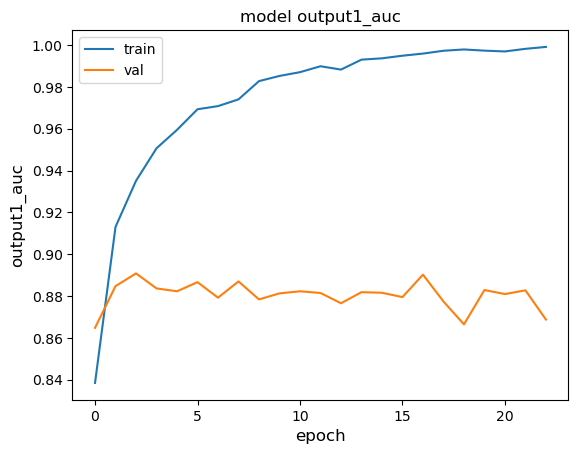

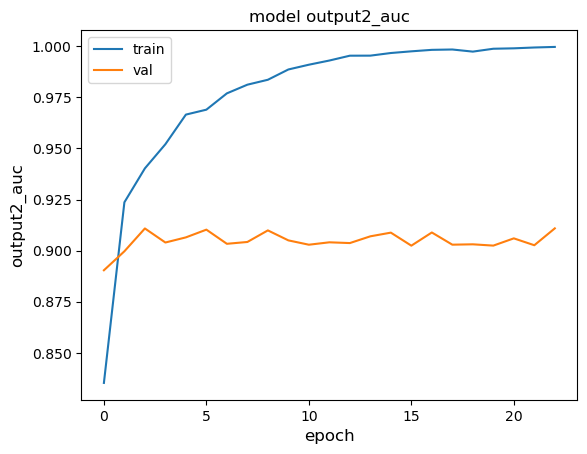

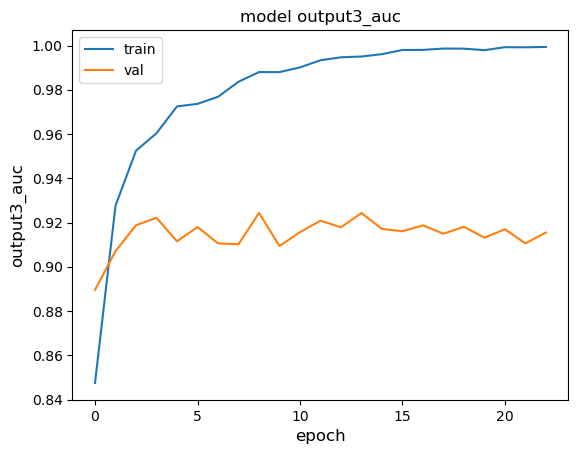

In [12]:
metrics = ["output1_auc","output2_auc", "output3_auc"]
for metric in metrics:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()

In [58]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 79, 1)]      0           []                               
                                                                                                  
 layer_normalization_570 (Layer  (None, 79, 1)       2           ['input_31[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 layer_normalization_578 (Layer  (None, 79, 1)       2           ['input_31[0][0]']               
 Normalization)                                                                                   
                                                                                           

 global_average_pooling1d_91 (G  (None, 79)          0           ['tf.__operators__.add_579[0][0]'
 lobalAveragePooling1D)                                          ]                                
                                                                                                  
 global_average_pooling1d_92 (G  (None, 79)          0           ['tf.__operators__.add_587[0][0]'
 lobalAveragePooling1D)                                          ]                                
                                                                                                  
 dense_90 (Dense)               (None, 128)          10240       ['global_average_pooling1d_90[0][
                                                                 0]']                             
                                                                                                  
 dense_91 (Dense)               (None, 128)          10240       ['global_average_pooling1d_91[0][
          

In [59]:
X

,additional_comments_length_mean_region0,additional_comments_length_mean_region1,additional_comments_length_mean_region2,additional_comments_length_sum_region0,additional_comments_length_sum_region1,additional_comments_length_sum_region2,all_text_length_mean_region0,all_text_length_mean_region1,all_text_length_mean_region2,all_text_length_sum_region0,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3_region_0,3.feed_24.PM10_UG_M3_region_1,3.feed_23.PM10_UG_M3_region_0,3.feed_23.CO_PPM..3.feed_23.CO_PPB_region_0,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_region_0,3.feed_1.SO2_PPM_region_0,3.feed_1.H2S_PPM_region_0,3.feed_1.SIGTHETA_DEG_region_0,3.feed_1.SONICWD_DEG_region_0,3.feed_1.SONICWS_MPH_region_0
datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00+00:00,3.427836,-0.460329,-0.632065,0.236966,-0.414667,-0.534024,2.998666,-0.848046,-0.856692,-0.241236,...,0.351022,0.429520,1.289698,0.910414,0.222308,1.618415,0.021854,1.132898,-1.052163,-0.996418
2016-11-02 00:00:00+00:00,-0.043208,5.356957,-0.497754,0.845788,0.471736,-0.290586,0.220473,4.361580,-0.305793,1.449155,...,1.187876,1.669449,3.497008,2.131927,1.307414,0.622728,-0.391097,-0.365414,-0.919044,-0.574417
2016-11-03 00:00:00+00:00,0.148608,-0.460329,0.256125,0.502278,-0.414667,0.423183,0.357349,-0.848046,0.260486,0.596431,...,-0.687044,-0.102437,0.204481,-0.616477,-0.066231,-0.463475,-0.391097,-0.321578,0.126188,0.220516
2016-11-04 00:00:00+00:00,-0.536974,-0.460329,-0.632065,-0.656718,-0.414667,-0.534024,-0.345330,-0.848046,0.028113,-0.691551,...,-1.350126,-0.947310,-0.938685,-0.952393,-1.604286,-0.463475,-0.391097,-0.333755,1.659523,-0.375684
2016-11-05 00:00:00+00:00,1.513576,1.250638,-0.632065,0.267686,-0.153960,-0.534024,1.524868,0.666999,-0.447060,-0.098888,...,-0.110849,0.363025,-0.185355,0.421809,0.177096,-0.017356,-0.391097,-0.733751,-0.447140,-0.797685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12 00:00:00+00:00,-0.536974,-0.460329,-0.459178,-0.656718,-0.414667,-0.432395,-0.648802,-0.215448,0.164657,-0.612164,...,-0.622108,-0.147844,-0.358721,-1.000000,-0.220777,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-07-13 00:00:00+00:00,-0.369020,-0.460329,-0.632065,-0.486360,-0.414667,-0.534024,-0.305803,-0.321767,-0.397905,-0.356210,...,-0.267375,0.077490,0.042317,-1.000000,-0.320245,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-07-14 00:00:00+00:00,-0.045503,-0.067440,-0.004850,-0.324380,-0.235069,-0.441849,-0.501180,-0.281011,0.246583,-0.576577,...,-0.286451,-0.286615,-0.074726,-1.000000,-0.265989,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
